# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import numpy as np
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #makes plt.show work when using jupyter

# Preprocessing and Opening Files

In [2]:
def preprocess_image(image_filepath: str, size: tuple) -> np.array:
    image = Image.open(image_filepath).convert('L').resize(size)
    return np.array(image).reshape((size[0], size[1], 1))


try:
    x_train = np.load("data/x_train.npy")
    y_train = np.load("data/y_train.npy")
except FileNotFoundError:
    training_files = glob('data/train/*.*')

    x_train = []
    y_train = []
    for filepath in training_files:
        x_train_image = preprocess_image(image_filepath=filepath, size=(28, 28))
        y_train_image = preprocess_image(image_filepath=filepath, size=(56, 56))
        x_train.append(x_train_image)
        y_train.append(y_train_image)

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    np.save("data/x_train.npy", x_train)
    np.save("data/y_train.npy", y_train)
    
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

norm = transforms.Normalize((0.5,), (0.5,))

x_train = torch.tensor(x_train, dtype=torch.float32)
x_train = norm(x_train/255)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = norm(y_train/255)
#print("Reg"+str(x_train/255))
#print("Norm"+str(norm(x_train/255)))
#x_train = data.TensorDataset(x_train.unsqueeze(1), y_train)


print(x_train.size()) # torch.Size([25000, 28, 28, 1])
x_train = x_train.squeeze(-1)
print(x_train.size()) # torch.Size([25000, 28, 28])

print(y_train.size()) # torch.Size([25000, 56, 56, 1])
y_train = y_train.squeeze(-1)
print(y_train.size()) # torch.Size([25000, 56, 56])


x_train = data.TensorDataset(x_train, y_train)

trainloader = data.DataLoader(x_train,
                                 shuffle=True,
                                 batch_size=128,
                                  
                             )

train_dev_sets = data.ConcatDataset([x_train, y_train])
train_dev_loader = data.DataLoader(dataset=train_dev_sets, shuffle=True, batch_size=128)
print(train_dev_loader.dataset) # torch.Size([25000, 28, 28, 1])

print(trainloader.dataset)
#print(x_train.shape)
#print(y_train.shape)

torch.Size([25000, 28, 28, 1])
torch.Size([25000, 28, 28])
torch.Size([25000, 56, 56, 1])
torch.Size([25000, 56, 56])


# Model

In [84]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # 32x28x28x1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # out: c x 3 x 3
        self.conv3 =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=1, padding=0) # out: c x 2 x 2
        self.fc = nn.Linear(in_features=256*2*2, out_features=2)

    def forward(self, x):
        #print(x.shape)
        # reshape into 128x1x28x28?
        x = x.unsqueeze(1)
        #print("x1:"+str(x.size())) # torch.Size([128, 1, 28, 28])
        x = F.relu(self.conv1(x))
        #print("x2:"+str(x.size())) # torch.Size([128, 128, 14, 14])
        x = F.relu(self.conv2(x))
        #print("x3:"+str(x.size())) # torch.Size([128, 256, 7, 7])
        x = self.pool(x) # torch.Size([128, 256, 3, 3])
        #print("xp:"+str(x.size()))
        x = F.relu(self.conv3(x))
        #print("x4:"+str(x.size())) # torch.Size([128, 256, 2, 2])
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        #print("x5:"+str(x.size())) # torch.Size([128, 1024])
        x = self.fc(x)
        #print("x6:"+str(x.size())) # torch.Size([128, 1])
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=2, out_features=256*2*2)
        self.conv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.convIB = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv0 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        #print("rx5:"+str(x.size())) # torch.Size([128, 1])
        x = self.fc(x)
        #print("rx4:"+str(x.size())) # torch.Size([128, 1024])
        x = x.view(x.size(0), 256, 2, 2) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        #print("rx3:"+str(x.size())) # torch.Size([128, 256, 2, 2])
        x = F.relu(self.conv3(x))
        #print("rx2:"+str(x.size())) # torch.Size([128, 128, 4, 4])
        x = F.relu(self.convIB(x))
        #print("rx2:"+str(x.size())) # torch.Size([128, 64, 7, 7])
        x = F.relu(self.conv2(x))
        #print("rx2:"+str(x.size())) # torch.Size([128, 64, 14, 14])
        x = F.relu(self.conv1(x))
        #print("rx1:"+str(x.size())) # torch.Size([128, 32, 28, 28])
        x = torch.tanh(self.conv0(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        #print("rx0:"+str(x.size())) # torch.Size([128, 1, 56, 56])
        
        x = x.squeeze(1) # remove the 1 for later comparison
        #print("rx-1:"+str(x.size())) # torch.Size([128, 56, 56])
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

autoencoder = Autoencoder()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1491363


In [85]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

num_ep = 100


print('Training ...')
for epoch in range(num_ep):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, image_output_batch in trainloader:
        
        #print(image_batch.type()) 
        image_batch = image_batch.to(device)
        
        #print(image_batch.type())
        #print(image_batch.shape)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        
        # We need to further process the data***
        #new_image_output_batch = []
        #y_image = []
        #x_image = []
        #for image in image_output_batch:
            # Go through each image within the batch
            #for x in image:
                
             #   for y in image:
               #     y_image.append(y/255)
              #  x_image.append(y_image)
                #print(x_image)
                #y_image = []
                
            #new_image_output_batch.append(image/255)
            #x_image = []
            #print(new_image_output_batch)
        
        #new_image_output_batch = np.array(new_image_output_batch)
        image_output_batch = image_output_batch
        image_output_batch = image_output_batch.to(device)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_output_batch)

        #print("Loss: "+str(loss))
        #print(image_batch_recon)
        #print("OUTPUT: "+str(image_output_batch))
        # backpropagation
        optimizer.zero_grad() # initialize the gradient

        #loss.requires_grad = True
        loss.backward() # backwards pass for gradient calc
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step() # w = w-a*gradient

        #print(optimizer)
        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_ep, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 0.177201
Epoch [2 / 100] average reconstruction error: 0.160033
Epoch [3 / 100] average reconstruction error: 0.158823
Epoch [4 / 100] average reconstruction error: 0.158044
Epoch [5 / 100] average reconstruction error: 0.157625
Epoch [6 / 100] average reconstruction error: 0.157327
Epoch [7 / 100] average reconstruction error: 0.157186
Epoch [8 / 100] average reconstruction error: 0.156113
Epoch [9 / 100] average reconstruction error: 0.155298
Epoch [10 / 100] average reconstruction error: 0.154918
Epoch [11 / 100] average reconstruction error: 0.154488
Epoch [12 / 100] average reconstruction error: 0.154489
Epoch [13 / 100] average reconstruction error: 0.153543
Epoch [14 / 100] average reconstruction error: 0.153218
Epoch [15 / 100] average reconstruction error: 0.152838
Epoch [16 / 100] average reconstruction error: 0.153543
Epoch [17 / 100] average reconstruction error: 0.153110
Epoch [18 / 100] average reconstruction erro

Got here


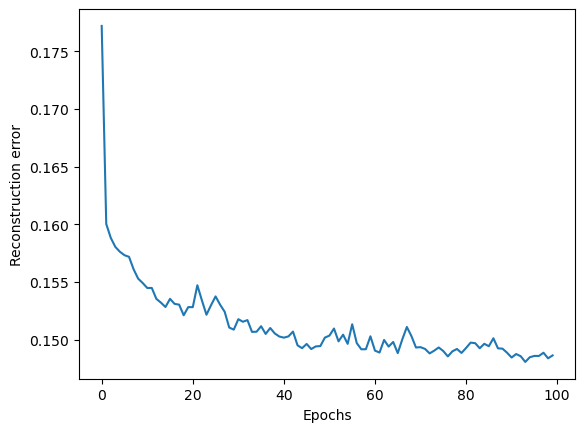

In [86]:
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)

plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
print("Got here")
plt.show()

In [67]:
#torch.save(autoencoder, )

Original images


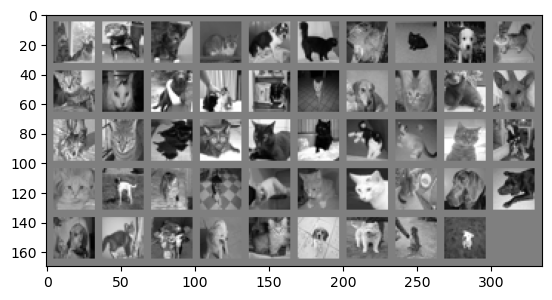

Autoencoder reconstruction:


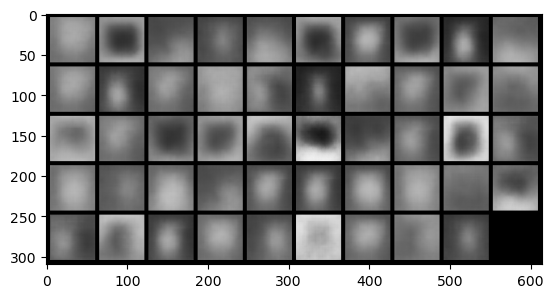

In [87]:
import numpy as np

#plt.ion()

import torchvision.utils

def preprocess_image(image_filepath: str, size: tuple) -> np.array:
    image = Image.open(image_filepath).convert('L').resize(size)
    return np.array(image)


try:
    test = np.load("data/test.npy")
    y_test =np.load("data/y_tests.npy")
except FileNotFoundError:
    test_files = glob('data/test1/*.*')

    test = []
    y_test = []
    for filepath in test_files:
        test_image = preprocess_image(image_filepath=filepath, size=(28, 28))
        y_test_image = preprocess_image(image_filepath=filepath, size=(56, 56))
        test.append(test_image)
        y_test.append(y_test_image)

    test = np.array(test).reshape((-1, 28, 28, 1))
    y_test = np.array(y_test).reshape((-1, 56, 56, 1))
    np.save("data/test.npy", test)
    np.save("data/y_tests.npy", y_test)


test = torch.tensor(test, dtype=torch.float32)
#print(test.size())
test = test.squeeze(1)
#print(test.size())
test = test.squeeze(3)
#print(test.size())
test = test.unsqueeze(1)
#print(test.size())

y_test = torch.tensor(y_test, dtype=torch.float32)
#print(y_test.size())
y_test = y_test.squeeze(1)
#print(y_test.size())
y_test = y_test.squeeze(3)
#print(y_test.size())
y_test = y_test.unsqueeze(1)
#print(y_test.size())

test = norm(test/255)

test = data.TensorDataset(test.squeeze(1), y_test)

test_dataloader = data.DataLoader(test,
                                 shuffle=True,
                                 batch_size=128
                             )

#print(test_dataloader.dataset)

autoencoder.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    #print(img.size())
    npimg = img.numpy()
    #print(npimg)
    npimg = np.transpose(npimg, (1, 2, 0))
    #print(npimg)
    plt.imshow(npimg)
    plt.show()
    #print("Passed show image.")

def visualise_output(images, model):
    #print("Entered visualize output.")
    with torch.no_grad():
        #print("Entered torch.no_grad.")
        images = images.to(device)
        #print(images.size()) # torch.Size([128, 1, 28, 28])
        images = images.squeeze(1)
        #print(images.size()) # torch.Size([128, 28, 28])
        images = model(images)
        #print(images)
        #print(images.size()) # torch.Size([128, 56, 56])
        images = images.unsqueeze(1)
        #print(images.size()) # torch.Size([128, 1, 56, 56])
        images = images.cpu()
        
        images = to_img(images)
        #print(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        #print(np_imagegrid)
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()
        #print("Passed torch.no_grad.")

images,_ = next(iter(test_dataloader))
#print(images.shape)
images = images.unsqueeze(1)
#print(images[0].shape)
# First visualise the original images
print('Original images')


grid = torchvision.utils.make_grid(images[1:50],10,5) # was 10, 5
#print(grid.shape)
show_image(grid)

#plt.show()
#print("Passed plot.show()") # kernel kept crashing, that is why you see the print spam
# https://github.com/matplotlib/matplotlib/issues/21513
# Matt came in clutch :D

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

In [88]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, image_output in test_dataloader:

    with torch.no_grad():
        #print(image_batch.size())
        image_batch = image_batch.to(device)
        image_output = image_output.to(device)
        #print(image_output.size())
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        #print(image_batch_recon.size())
        image_batch_recon = image_batch_recon.unsqueeze(1)
        #print(image_batch_recon.size())
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, norm(image_output/255))

        #print(norm(image_output/255))
        #print(image_batch_recon) # full of 1s, why tho?, it is float32 hmm
        # now it just is full of a single number, hmm
        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.147041
